<h1 align="center"> Pre-trained models with Resnet-18 for Concrete Crack Images Classification</h1>

***
AI Capstone Project with Deep Learning: Week 4

<h2 id="download_data">Download Data</h2>

In this section, you are going to download the data from IBM object storage using <b>wget</b>, then unzip them.  <b>wget</b> is a command the retrieves content from web servers, in this case its a zip file. Locally we store the data in the directory  <b>/resources/data</b> . The <b>-p</b> creates the entire directory tree up to the given directory.


First, we download the file that contains the images, if you dint do this in your first lab uncomment:


In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

We then unzip the file, this ma take a while:

In [2]:
#!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

We then download the files that contain the negative images:


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab:

In [3]:
import os
import glob
import numpy as np

import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torch import optim 
torch.manual_seed(0)

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


In [4]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="./resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>

Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [6]:
train_dataset = Dataset(transform=transform,train=True)
validation_dataset = Dataset(transform=transform,train=False)

We  can find the shape of the image:

In [7]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

We see that it's a color image with three channels:

In [8]:
size_of_image=3*227*227
size_of_image

154587

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


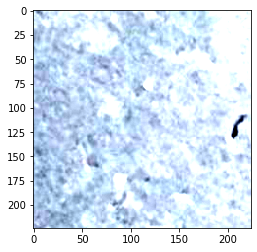

In [9]:
img = np.transpose(train_dataset[1][0], (1,2,0)).numpy()
print(img.shape)
plt.imshow(img, )

<h2 > Train the Model <h2>

<b>Model Object:</b>

In [10]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.fc=nn.Linear(512, 2)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Optimizer:</b>

In [12]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.003)

<b>Criterion:</b>

In [13]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=15)

<b>Train Model with 20 epochs</b>

In [15]:
n_epochs = 20
loss_list = []
accuracy_list= []
correct = 0
n_test = len(validation_dataset)

In [16]:
def train(epoch):
    loss_sublist = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        model.train()
        optimizer.zero_grad()
        
        z = model(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    
    print("[Epoch: %d] loss:%.3f" % (epoch+1, np.mean(loss_sublist)))
    return np.mean(loss_sublist) 

In [17]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            z = model(x_test)
            _, yhat = torch.max(z.data, dim=1)
            correct += (yhat == y_test).sum().item()
            total += yhat.size(0)
    accuracy = correct/total
    print("Accuracy on test set: {} % ({} / {})".format(round(100*accuracy, 2), correct, total))
    return 100*accuracy

In [18]:
loss_list = []
accuracy_list = []
for epoch in range(20):
    loss = train(epoch)
    accuracy = test()
    loss_list.append(loss)
    accuracy_list.append(accuracy)

[Epoch: 1] loss:0.025
Accuracy on test set: 99.18 % (9918 / 10000)
[Epoch: 2] loss:0.018
Accuracy on test set: 99.12 % (9912 / 10000)
[Epoch: 3] loss:0.017
Accuracy on test set: 99.26 % (9926 / 10000)
[Epoch: 4] loss:0.016
Accuracy on test set: 99.09 % (9909 / 10000)
[Epoch: 5] loss:0.014
Accuracy on test set: 99.21 % (9921 / 10000)
[Epoch: 6] loss:0.013
Accuracy on test set: 99.17 % (9917 / 10000)
[Epoch: 7] loss:0.011
Accuracy on test set: 98.98 % (9898 / 10000)
[Epoch: 8] loss:0.012
Accuracy on test set: 98.91 % (9891 / 10000)
[Epoch: 9] loss:0.013
Accuracy on test set: 99.12 % (9912 / 10000)
[Epoch: 10] loss:0.013
Accuracy on test set: 99.15 % (9915 / 10000)
[Epoch: 11] loss:0.010
Accuracy on test set: 99.2 % (9920 / 10000)
[Epoch: 12] loss:0.012
Accuracy on test set: 99.15 % (9915 / 10000)
[Epoch: 13] loss:0.009
Accuracy on test set: 99.18 % (9918 / 10000)
[Epoch: 14] loss:0.008
Accuracy on test set: 99.16 % (9916 / 10000)
[Epoch: 15] loss:0.007
Accuracy on test set: 99.15 % (9915

In [19]:
print(loss_list)
print(accuracy_list)

[0.025461727144107583, 0.018104552401859826, 0.017325301599249974, 0.01643879677704784, 0.014143769250782983, 0.01258738643409412, 0.011406699124962106, 0.011575919780501391, 0.012519822185249194, 0.012582431441956633, 0.010168350549493528, 0.011541699119509715, 0.009319367115242606, 0.00840631683445436, 0.007024816889888605, 0.008113321494697052, 0.009127967541603091, 0.0062114688719265825, 0.009045725096826388, 0.0063174682099545925]
[99.18, 99.11999999999999, 99.26, 99.09, 99.21, 99.17, 98.98, 98.91, 99.11999999999999, 99.15, 99.2, 99.15, 99.18, 99.16, 99.15, 99.16, 99.11, 98.8, 99.22, 99.2]


**the figure of loss and accuracy**

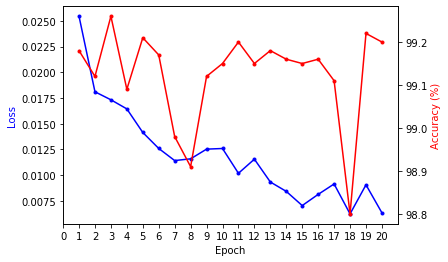

In [20]:
x = list(range(1, 21))
         
fig,left_axis=plt.subplots()
right_axis = left_axis.twinx()
 
p1 = left_axis.plot(x, loss_list, 'b.-')
p2 = right_axis.plot(x, accuracy_list, 'r.-')

left_axis.set_xlim(0, 21)
left_axis.set_xticks(range(0,21,1))

left_axis.set_xlabel('Epoch')
left_axis.set_ylabel('Loss', color='b')
right_axis.set_ylabel('Accuracy (%)', color='r')

plt.show()

**get the wrong classified images**

In [34]:
y_test_label = []
y_hat_label = []

In [35]:
with torch.no_grad():
    for x_test, y_test in validation_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        z = model(x_test)
        _, yhat = torch.max(z.data, dim=1)
        
        y_test_label.extend(y_test.tolist())
        y_hat_label.extend(yhat.tolist())

In [53]:
misclassified_samples = [i for i in range(len(y_hat_label)) if y_test_label[i]!=y_hat_label[i]]
print(len(misclassified_samples))
print(misclassified_samples)

80
[18, 62, 180, 452, 550, 572, 732, 794, 1035, 1178, 1212, 1244, 1583, 1935, 2090, 2429, 2540, 2624, 2647, 3100, 3265, 3377, 3474, 3640, 3897, 4270, 4566, 4600, 4652, 4759, 4780, 4900, 4928, 5282, 5352, 5427, 5852, 6070, 6275, 6276, 6314, 6533, 6544, 6617, 6682, 6790, 6844, 6922, 6930, 7016, 7294, 7352, 7454, 7474, 7560, 7586, 7594, 7621, 8032, 8093, 8099, 8276, 8395, 8480, 8562, 8631, 8722, 8755, 8906, 8920, 8944, 8970, 9219, 9405, 9449, 9746, 9753, 9762, 9843, 9930]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


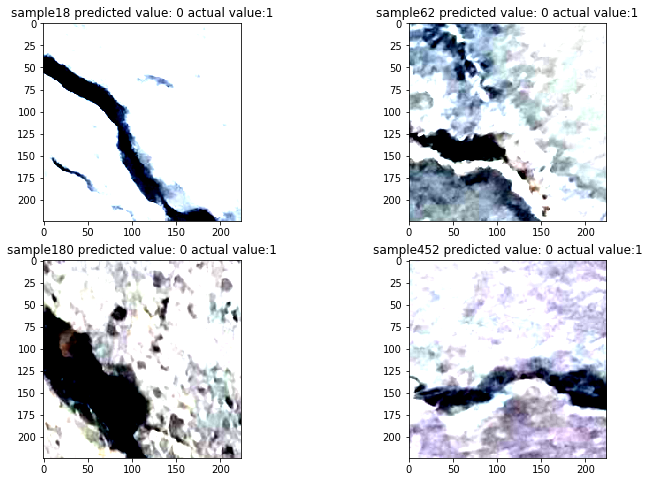

In [62]:
plt.figure(22, figsize=(12,8))
for m in range(4):
    i = misclassified_samples[m]
    img = np.transpose(validation_dataset[i][0], (1,2,0))
    plt.subplot(221+m)
    plt.title("sample{} predicted value: {} actual value:{}".format(i, y_hat_label[i], y_test_label[i]))
    plt.imshow(img)